## Mobile Health Human Behavior Analysis

In [1]:
# 設定亂數種子數值
seed_value= 4
# 1. 設定 Python 環境變數亂數種子
import os
os.environ['PYTHONHASHSEED']=str(seed_value)
# 2. 設定 Python 內建亂數生成器亂數種子
import random
random.seed(seed_value)
# 3. 設定 Numpy 亂數種子
import numpy as np
np.random.seed(seed_value)
# 4. 設定 TensorFlow 亂數種子
import tensorflow as tf
tf.random.set_seed(seed_value)

2023-11-13 22:22:43.352075: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Colab 進行matplotlib繪圖時顯示繁體中文
# 下載台北思源黑體並命名taipei_sans_tc_beta.ttf，移至指定路徑
!gdown 1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_

import matplotlib as mpl
import matplotlib.pyplot as plt 
from matplotlib.font_manager import fontManager

fontManager.addfont('TaipeiSansTCBeta-Regular.ttf')
mpl.rc('font', family='Taipei Sans TC Beta')

Downloading...
From: https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
To: /Users/yilintsai/Desktop/GitHub/my-github/2023-15th-ironman/TaipeiSansTCBeta-Regular.ttf
100%|██████████████████████████████████████| 20.7M/20.7M [00:02<00:00, 8.16MB/s]


## 載入資料集

- L1: Standing still (1 min)
- L2: Sitting and relaxing (1 min)
- L3: Lying down (1 min)
- L4: Walking (1 min)
- L5: Climbing stairs (1 min)

In [3]:
import pandas as pd
df_data =  pd.read_csv('https://github.com/andy6804tw/2023-15th-ironman/raw/main/dataset/mHealth_subject1.csv')
x_feature_names = ['acc_l_ankle_x','acc_l_ankle_y','acc_l_ankle_z','gyro_l_ankle_x','gyro_l_ankle_y','gyro_l_ankle_z']
y_feature_name = ['label']
y_label_names = ['站立', '靜坐', '平躺', '走路', '上樓']
df_data = df_data[x_feature_names + y_feature_name]
df_data

,acc_l_ankle_x,acc_l_ankle_y,acc_l_ankle_z,gyro_l_ankle_x,gyro_l_ankle_y,gyro_l_ankle_z,label
0,2.1849,-9.6967,0.63077,0.103900,-0.84053,-0.68762,0
1,2.3876,-9.5080,0.68389,0.085343,-0.83865,-0.68369,0
2,2.4086,-9.5674,0.68113,0.085343,-0.83865,-0.68369,0
3,2.1814,-9.4301,0.55031,0.085343,-0.83865,-0.68369,0
4,2.4173,-9.3889,0.71098,0.085343,-0.83865,-0.68369,0
...,...,...,...,...,...,...,...
161275,2.1463,-9.2841,2.28640,-0.888680,-0.95497,0.88409,0
161276,2.0773,-9.5717,2.24010,-0.903530,-0.96998,0.86640,0
161277,1.7497,-9.3127,2.39560,-0.903530,-0.96998,0.86640,0
161278,1.8910,-9.3342,2.21890,-0.903530,-0.96998,0.86640,0


依 label 將資料切割，資料取樣率為50Hz，每種動作分別搜集約一分鐘的訊號，因此每筆資料大小約 3072 rows x 4 columns

In [4]:
L1 = df_data.loc[ df_data.label == 1] #L1: 站立 (1 min) 
L2 = df_data.loc[ df_data.label == 2] #L2: 靜坐 (1 min)
L3 = df_data.loc[ df_data.label == 3] #L3: 平躺 (1 min)
L4 = df_data.loc[ df_data.label == 4] #L4: 走路 (1 min)
L5 = df_data.loc[ df_data.label == 5] #L5: 上樓 (1 min)

## 資料視覺化
顯示前500筆(10秒)

In [5]:
def plot_data_10s(data, title, normalize=True):
    data_10s = data.loc[ : ,"acc_l_ankle_x":"gyro_l_ankle_z"]
    data_10s = data_10s[ :500]
    data_10s = data_10s.reset_index(drop=True)
    if(normalize):
        # 經過標準化 sqrt(變異數) = 標準差
        mean = data_10s.mean(axis=0)
        std = data_10s.std(axis=0)
        data_10s -= mean
        data_10s /= std
    chart = data_10s.plot( #kind='bar',  #圖表類型
            title=title,
            legend=True,  # 是否顯示圖例
            figsize=(10, 5))  # 圖表大小
    if(normalize):
        plt.ylim((-5,5))
    else:
        plt.ylim((-30,30))
    # plt.savefig(f'{title}.png', dpi=300)
    plt.show()

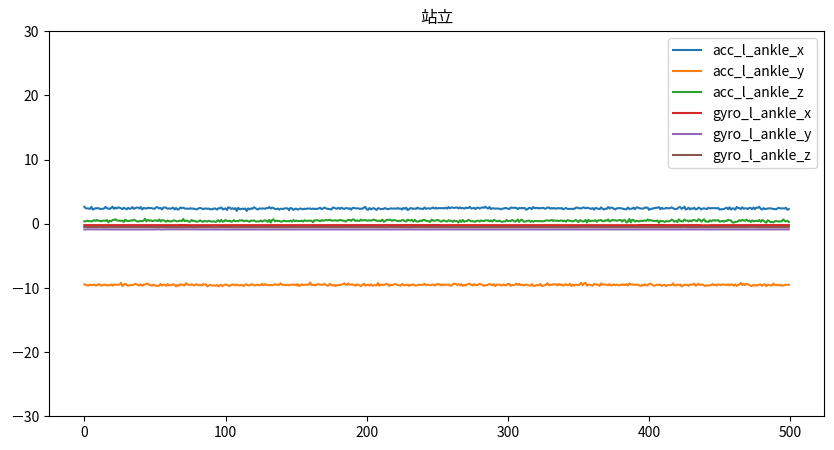

In [6]:
# 繪製站立10秒訊號(原始數據)
plot_data_10s(L1, title='站立', normalize=False)

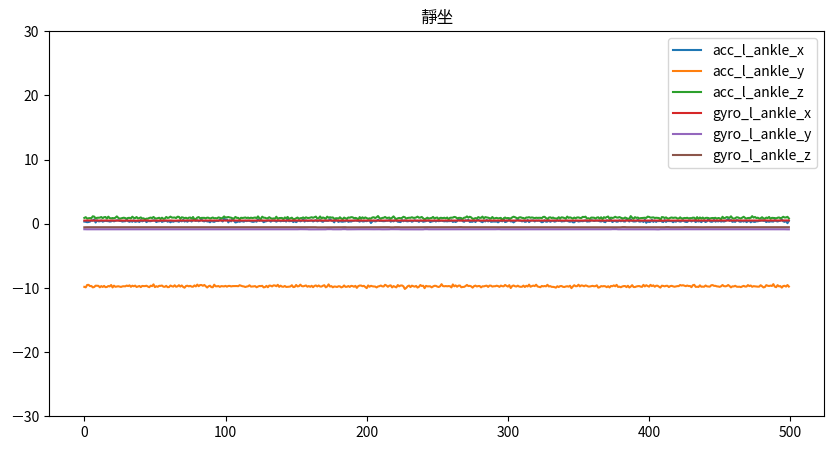

In [7]:
# 繪製靜坐10秒訊號(原始數據)
plot_data_10s(L2, title='靜坐', normalize=False)

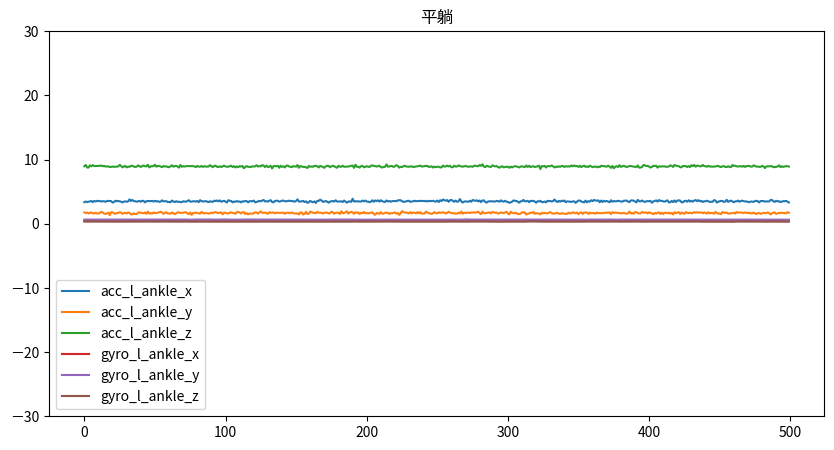

In [8]:
# 繪製平躺10秒訊號(原始數據)
plot_data_10s(L3, title='平躺', normalize=False)

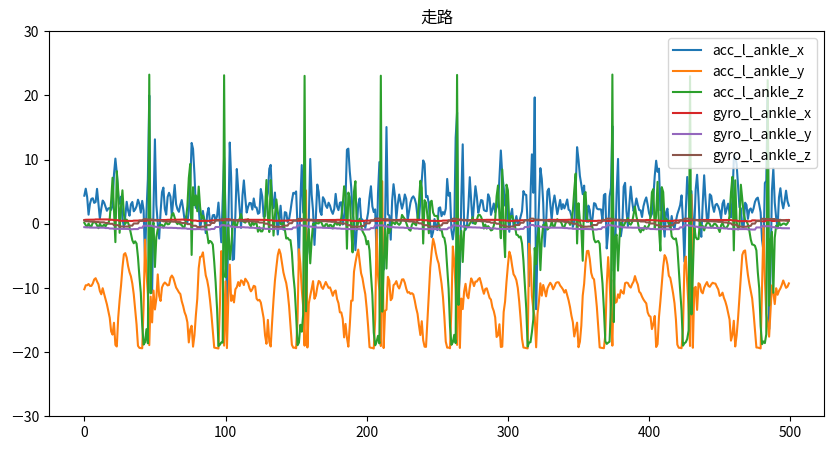

In [9]:
# 繪製走路10秒訊號(原始數據)
plot_data_10s(L4, title='走路', normalize=False)

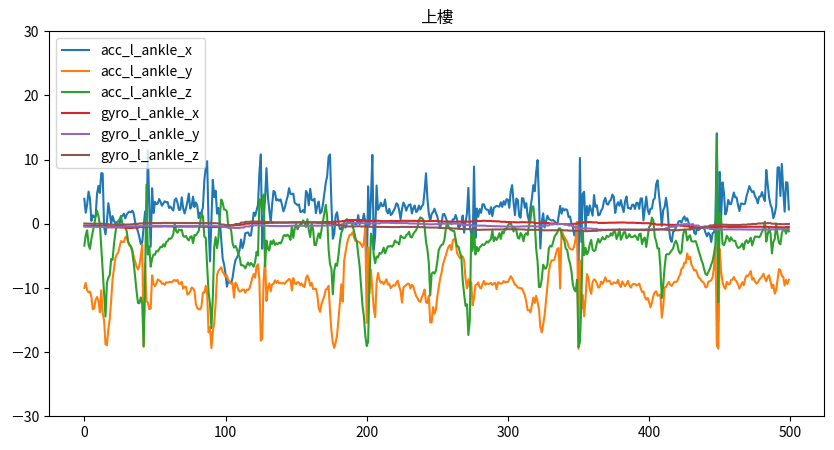

In [10]:
# 繪製上樓10秒訊號(原始數據)
plot_data_10s(L5, title='上樓', normalize=False)

# 資料預處理
這裡的意思是1分鐘3072筆的資料取視窗大小100點資料，接著移動50點再另外收集。

In [11]:
# 抓取window_size的資料作為觀察資料(x), 預測下一時間點步態(y)
def window_data(data, window_size, shift):
    X = []
    y = []
    i = 0
    while (i + window_size) <= len(data) - 1:
        # 將連續的window_size時間段內的資料（去除最後一個特徵label）作為觀察資料x
        X.append(data[i:i+window_size, :-1])
        # 將接下來的一個時間點的第6個特徵（標籤）作為預測資料y
        y.append(data[i+window_size, 6])
        i += shift  # 移動索引，以繼續抓取下一筆資料
    X = np.array(X)
    y = np.array(y).reshape(-1)
    assert len(X) == len(y)  # 確保觀察資料和預測資料的數量一致
    return X, y  # 返回處理後的時序資料和預測資料

In [12]:
# 蒐集六個訊號100個時間點(window_size)，每筆資料採樣移動20個資料點
X_L1, y_L1 = window_data(L1.values, window_size=100, shift=20)
X_L2, y_L2 = window_data(L2.values, window_size=100, shift=20)
X_L3, y_L3 = window_data(L3.values, window_size=100, shift=20)
X_L4, y_L4 = window_data(L4.values, window_size=100, shift=20)
X_L5, y_L5 = window_data(L5.values, window_size=100, shift=20)

X = np.concatenate([X_L1, X_L2, X_L3, X_L4, X_L5])
y = np.concatenate([y_L1, y_L2, y_L3, y_L4, y_L5])-1 # 標籤要從0開始故全部減一
print("X shape: ",X.shape)
print("y shape: ",y.shape)

X shape:  (745, 100, 6)
y shape:  (745,)


## 切割資料集

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state=42, stratify=y)
print("X_train shape = ",X_train.shape)
print("X_test shape = ",X_test.shape)
print("y_train shape = ",y_train.shape)
print("y_test shape = ",y_test.shape)

X_train shape =  (670, 100, 6)
X_test shape =  (75, 100, 6)
y_train shape =  (670,)
y_test shape =  (75,)


## 模型建立

In [14]:
from tensorflow.keras.models import Model
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.compat.v1.keras.backend import get_session
tf.compat.v1.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


## 1DCNN

In [15]:
num_sensor = 6
window_size = 100

def build_1dcnn_model():
    model_input = layers.Input(shape=(window_size, num_sensor))
    
    # Flatten the input
    flattened_input = layers.Flatten()(model_input)
    
    # Normalization layer
    normalization_layer = tf.keras.layers.Normalization(axis=1)
    normalization_layer.adapt(x_train.reshape(-1, window_size * num_sensor))
    normalized_input = normalization_layer(flattened_input)
    
    # Reshape back to original shape
    reshaped_input = layers.Reshape((window_size, x_train.shape[-1]))(normalized_input)
    
    # Rest of the model
    x = layers.Conv1D(4, 2, activation='relu')(reshaped_input)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Flatten()(x)
    # x = layers.Dense(32, activation='relu')(x)
    model_output = layers.Dense(5, activation='softmax')(x)
    
    return Model(model_input, model_output)


## LSTM

In [16]:
num_sensor = 6
window_size = 100
def build_model():
    model_input = layers.Input(shape=(window_size, num_sensor))
    # 輸出層
    x = layers.LSTM(2, activation='relu', return_sequences=True, return_state=False)(model_input)
    x = layers.Flatten()(x)
    # 輸出層
    model_output = layers.Dense(5, activation='softmax')(x)
    return Model(model_input, model_output)


In [17]:
tf.keras.backend.clear_session()
model = build_model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 6)]          0         
                                                                 
 lstm (LSTM)                 (None, 100, 2)            72        
                                                                 
 flatten (Flatten)           (None, 200)               0         
                                                                 
 dense (Dense)               (None, 5)                 1005      
                                                                 
Total params: 1077 (4.21 KB)
Trainable params: 1077 (4.21 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Training

In [18]:
# 編譯模型
model.compile(
      loss='sparse_categorical_crossentropy',
      optimizer='adam',
      metrics=['acc'])
# 訓練模型
history = model.fit( X_train, y_train, 
                    validation_split=0.1,
                    batch_size=4,
                    epochs=10)

Train on 603 samples, validate on 67 samples
Epoch 1/10


2023-11-13 22:23:00.224500: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:382] MLIR V1 optimization pass is not enabled
2023-11-13 22:23:00.250004: W tensorflow/c/c_api.cc:305] Operation '{name:'training/Adam/dense/kernel/v/Assign' id:619 op device:{requested: '', assigned: ''} def:{{{node training/Adam/dense/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/dense/kernel/v, training/Adam/dense/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


603/603 [==============================] - 2s 3ms/sample - loss: 1.3290 - acc: 0.3698 - val_loss: 1.1693 - val_acc: 0.3582
Epoch 2/10
 24/603 [>.............................] - ETA: 1s - loss: 1.0067 - acc: 0.5000

/Users/yilintsai/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2023-11-13 22:23:02.263118: W tensorflow/c/c_api.cc:305] Operation '{name:'loss/mul' id:245 op device:{requested: '', assigned: ''} def:{{{node loss/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss/mul/x, loss/dense_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


603/603 [==============================] - 2s 3ms/sample - loss: 1.0153 - acc: 0.4312 - val_loss: 1.0362 - val_acc: 0.3731
Epoch 3/10
603/603 [==============================] - 2s 3ms/sample - loss: 0.8746 - acc: 0.4643 - val_loss: 0.9554 - val_acc: 0.4030
Epoch 4/10
603/603 [==============================] - 3s 4ms/sample - loss: 0.8470 - acc: 0.4992 - val_loss: 0.9143 - val_acc: 0.4030
Epoch 5/10
603/603 [==============================] - 2s 3ms/sample - loss: 0.7986 - acc: 0.5240 - val_loss: 0.8817 - val_acc: 0.4030
Epoch 6/10
603/603 [==============================] - 2s 3ms/sample - loss: 0.7584 - acc: 0.5506 - val_loss: 0.8518 - val_acc: 0.4478
Epoch 7/10
603/603 [==============================] - 2s 3ms/sample - loss: 0.7204 - acc: 0.6932 - val_loss: 0.8265 - val_acc: 0.6567
Epoch 8/10
603/603 [==============================] - 2s 3ms/sample - loss: 0.6827 - acc: 0.6998 - val_loss: 0.8045 - val_acc: 0.6866
Epoch 9/10
603/603 [==============================] - 2s 3ms/sample - los

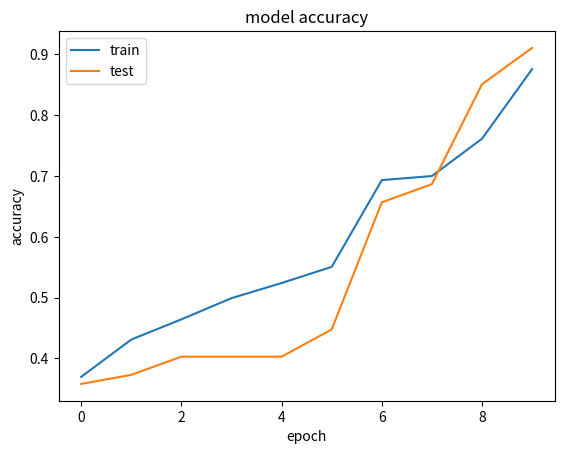

In [19]:
import matplotlib.pyplot as plt
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

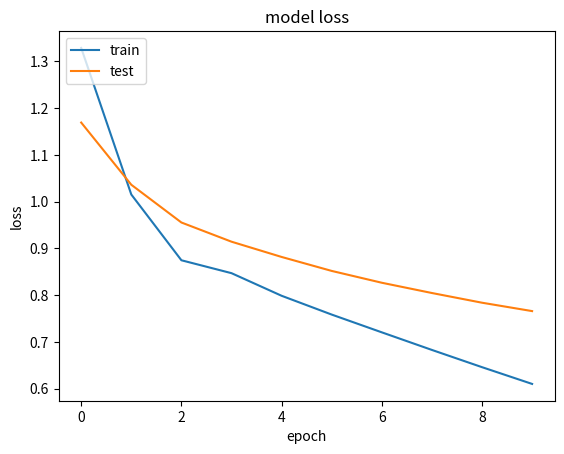

In [20]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [21]:
# Evaluate the model on test set
test_result = model.evaluate(x = X_test, y = y_test, batch_size = X_test.shape[0])
# Print test loss and test accuracy
print("Loss on testing set: %f" % test_result[0])
print("Accuracy on testing set: %f" % test_result[1])

Loss on testing set: 0.809385
Accuracy on testing set: 0.840000


In [22]:
pred = model.predict(np.array([X_test[0]])).argmax(axis=1)[0]
print(f'Predict: {pred}, Ground True: {y_test[0]}')

Predict: 1, Ground True: 1.0


/Users/yilintsai/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2023-11-13 22:23:44.278550: W tensorflow/c/c_api.cc:305] Operation '{name:'dense/Softmax' id:187 op device:{requested: '', assigned: ''} def:{{{node dense/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


In [23]:
model.predict(X_test).argmax(axis=1)

array([1, 2, 0, 3, 0, 1, 0, 4, 4, 3, 1, 0, 1, 1, 0, 4, 4, 1, 2, 4, 1, 4,
       4, 4, 3, 4, 1, 0, 0, 1, 0, 4, 3, 4, 0, 1, 2, 3, 4, 4, 4, 2, 4, 1,
       3, 1, 2, 1, 2, 0, 2, 2, 3, 1, 2, 1, 0, 1, 1, 1, 0, 3, 3, 0, 2, 1,
       2, 2, 2, 0, 2, 4, 1, 2, 0])

In [24]:
from sklearn.metrics import classification_report, confusion_matrix


pred_valid = model.predict(X_test).argmax(axis=1)
print(classification_report(y_test, pred_valid))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        15
         1.0       0.75      1.00      0.86        15
         2.0       1.00      1.00      1.00        15
         3.0       0.67      0.40      0.50        15
         4.0       0.75      0.80      0.77        15

    accuracy                           0.84        75
   macro avg       0.83      0.84      0.83        75
weighted avg       0.83      0.84      0.83        75



## SHAP

In [ ]:
!pip install -q shap

In [25]:
import shap
shap.initjs()

# 使用 Deep SHAP 解釋模型
explainer = shap.DeepExplainer(model=model, data=X_train)
# 估計 Shapely values
shap_values = explainer.shap_values(X_test)

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.


AssertionError: The SHAP explanations do not sum up to the model's output! This is either because of a rounding error or because an operator in your computation graph was not fully supported. If the sum difference of %f is significant compared to the scale of your model outputs, please post as a github issue, with a reproducible example so we can debug it. Used framework: tensorflow - Max. diff: 51.6516422720299 - Tolerance: 0.01

In [ ]:
# 5個類別, 75筆測試資料, 100個時間點, 6個特徵
np.array(shap_values).shape

## SHAP Summary Plot (全局解釋)

In [ ]:
def normalize_array(arr):
    # 計算陣列中所有元素的總和
    total = sum(arr)
    # 正規化每個元素
    normalized_arr = [x / total for x in arr]
    return normalized_arr

In [ ]:
# 獲得在某標籤下每個特徵對於整體平均貢獻的值
# 0:站立、1:靜坐、2:平躺、3:走路、4:上樓
label=4
shap_value = np.array(shap_values)
shap_value = np.absolute(shap_value[label])
shap_value = np.sum(shap_value, axis=1)
SHAP_list = [np.sum(shap_value[:, 0]), np.sum(shap_value[:, 1]), np.sum(shap_value[:, 2]), np.sum(shap_value[:, 3]), np.sum(shap_value[:, 4]), np.sum(shap_value[:, 5])]
plt.barh(x_feature_names, normalize_array(SHAP_list), label=y_label_names[label], color='#028bfb')
# plt.legend()
# plt.tight_layout()
plt.savefig('plot.png', dpi=300)
plt.show()

In [ ]:
# to get the shape values or each feature
shap_df = pd.DataFrame(list(dict(zip(x_feature_names, normalize_array(SHAP_list))).items()),
             columns=['features','shapvals']).sort_values(by='shapvals', ascending=False)
shap_df

### SHAP Force plot (單筆資料解釋)

In [ ]:
shap.initjs()
# 觀察測試集中第一筆資料的重要程度
index=0
pred_class = model.predict(X_test[[index]]).argmax()
pred_proba = model.predict(X_test[[index]])[0][pred_class]
print(f'測試集第 {index+1} 筆模型預測結果: {pred_class} 機率值: {pred_proba}')
print(f'真實答案: {int(y_test[index])} ({y_label_names[pred_class]})')
shap_value = shap_values[pred_class][index]
shap_value = shap_value.sum(axis=0)
shap.force_plot(explainer.expected_value[pred_class], shap_value, feature_names=x_feature_names)

In [ ]:
# 把(100,6)所有數值加總+基準值
shap_values[pred_class][index].sum()+explainer.expected_value[pred_class]

In [ ]:
# 把六個特徵shap_value加總+基準值
shap_value.sum()+explainer.expected_value[pred_class]

### SHAP waterfall plot (單筆資料解釋)

In [ ]:
pred_class = model.predict(X_test[[index]]).argmax()
pred_proba = model.predict(X_test[[index]])[0][pred_class]
shap_value = np.array(shap_values)
shap_value = np.expand_dims((shap_value[pred_class])[index], axis=0)
shap_value = np.sum(shap_value, axis=1)[0]
shap.waterfall_plot(shap.Explanation(values=shap_value, 
                                    base_values=explainer.expected_value[pred_class],  
                                    feature_names=x_feature_names))

In [ ]:
shap.initjs()
shap.force_plot(0, shap_values[pred_class][index], feature_names=x_feature_names)

## Reference
- [[forecast][LSTM+SHAP]Applied SHAP on the polynomial equation case with LSTM algorithm](https://medium.com/@sakamoto2000.kim/applied-shap-on-the-polynomial-equation-case-with-lstm-algorithm-7c140d15736b)